## **Part 0: Loading the libraries and the data [0 Marks]**


In this project, we want to develop a statistical model for the mortality rate of lung cancer in the United States.

One of the parts overlooked in many machine learning projects is preprocessing. And a good way to learn it is by solving a lot of examples and test cases. A big part of this project is walking you through preprocessing, making informed decisions using your observations, and exploratory data analysis. Then we use supervised learning methods to construct models to predict the mortality rate of lung cancer using the features provided here.

In [5]:
# data wrangling tools
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# statistical learning
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


## Loading data
Load the three csv files as pandas dataframes directly from their URLs.

In [6]:
fulldf = pd.read_csv('https://saref.github.io/teaching/BAIT509/mydata.csv').drop(columns='Unnamed: 0')
data_dict = pd.read_csv('https://saref.github.io/teaching/BAIT509/descriptions.csv')
populationdf = pd.read_csv('https://saref.github.io/teaching/BAIT509/populations.csv').drop(columns='Unnamed: 0')

Data set `mydata.csv` includes most of the data. Explanations on the meaning of each of the columns are included in `descriptions.csv`. Please take your time to understand the three dataframes before proceeding.

## **Part 1: Getting started [40 Marks]**

## Data cleaning
In this project, we go through specific data cleaning steps. Please read through the instructions carefully.


### 1.1 Convert `FIPS` column to correct format [5 Marks]
Federal Information Processing Standard or [FIPS](https://en.wikipedia.org/wiki/FIPS_county_code) is a categorical variable. It is a code with five digits. The left two digits showing the state and the three right digits showing the county code. We recognize that desipite being a number, FIPS is actually a categorical variable.
First, check the format of the `FIPS` column and convert them to the five digit format with type `np.object_` as seen in the county level section, [here](https://transition.fcc.gov/oet/info/maps/census/fips/fips.txt#:~:text=county%2Dlevel%20%20%20%20%20%20place). 

*Hint*: You can use [apply](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html) to first convert the type and then use [`str.pad`](https://pandas.pydata.org/docs/reference/api/pandas.Series.str.pad.html) to format the values as five digit numbers.

In [7]:
fulldf['FIPS'] = fulldf['FIPS'].astype('str')
fulldf['FIPS'] = fulldf['FIPS'].str.pad(width=5, side='left', fillchar='0')

In [8]:
fulldf.head()

,State,AreaName,All_Poverty,M_Poverty,F_Poverty,FIPS,Med_Income,Med_Income_White,Med_Income_Black,Med_Income_Nat_Am,...,M_Without,F_With,F_Without,All_With,All_Without,Incidence_Rate,Avg_Ann_Incidence,Recent_Trend,Mortality_Rate,Avg_Ann_Deaths
0,AK,"Aleutians East Borough, Alaska",553,334,219,02013,61518.0,72639.0,31250.0,54750.0,...,1317,566,540,1442,1857,*,3 or fewer,*,*,*
1,AK,"Aleutians West Census Area, Alaska",499,273,226,02016,84306.0,97321.0,93750.0,48750.0,...,769,1707,564,4177,1333,*,3 or fewer,*,*,*
2,AK,"Anchorage Municipality, Alaska",23914,10698,13216,02020,78326.0,87235.0,50535.0,53935.0,...,23245,122426,21393,243173,44638,61.5,131,stable,47.3,96
3,AK,"Bethel Census Area, Alaska",4364,2199,2165,02050,51012.0,92647.0,73661.0,41594.0,...,2708,6627,1774,13023,4482,62.7,6,stable,58.3,5
4,AK,"Bristol Bay Borough, Alaska",69,33,36,02060,79750.0,88000.0,NaN,63333.0,...,124,349,67,768,191,*,3 or fewer,*,*,*


### 1.2 Check for null values [5 Marks]

Just check for null values and remove columns whenever the percentage of null values is greater than 20. Please briefly justify your choices w.r.t. the columns you have removed.

In [9]:
fulldf.isnull().sum()

State                     0
AreaName                  0
All_Poverty               0
M_Poverty                 0
F_Poverty                 0
FIPS                      0
Med_Income                1
Med_Income_White          2
Med_Income_Black       1210
Med_Income_Nat_Am      1660
Med_Income_Asian       1757
Med_Income_Hispanic     681
M_With                    0
M_Without                 0
F_With                    0
F_Without                 0
All_With                  0
All_Without               0
Incidence_Rate            0
Avg_Ann_Incidence         0
Recent_Trend              0
Mortality_Rate            0
Avg_Ann_Deaths            0
dtype: int64

In [10]:
missing_vals_df = pd.DataFrame()

col_names_list = []
missing_val_pct_list = []

for col in fulldf.columns : 
    
    col_names_list.append(col)
    missing_val_pct_list.append(fulldf[col].isnull().sum()/len(fulldf[col])*100)
    
missing_vals_df['col'] = col_names_list
missing_vals_df['missing_val_pct'] = missing_val_pct_list

In [11]:
missing_vals_df

,col,missing_val_pct
0,State,0.000000
1,AreaName,0.000000
2,All_Poverty,0.000000
3,M_Poverty,0.000000
4,F_Poverty,0.000000
5,FIPS,0.000000
6,Med_Income,0.031908
7,Med_Income_White,0.063816
8,Med_Income_Black,38.608807
9,Med_Income_Nat_Am,52.967454


In [12]:
more_than_20_pct_cols = list(missing_vals_df[missing_vals_df['missing_val_pct'] >= 20]['col'].unique())
more_than_20_pct_cols

['Med_Income_Black',
 'Med_Income_Nat_Am',
 'Med_Income_Asian',
 'Med_Income_Hispanic']

The above columns have more than 20% missing values and are hence removed from the dataset. 

In [13]:
fulldf = fulldf.drop(columns=more_than_20_pct_cols, axis = 1)

In [14]:
fulldf.isnull().sum()

State                0
AreaName             0
All_Poverty          0
M_Poverty            0
F_Poverty            0
FIPS                 0
Med_Income           1
Med_Income_White     2
M_With               0
M_Without            0
F_With               0
F_Without            0
All_With             0
All_Without          0
Incidence_Rate       0
Avg_Ann_Incidence    0
Recent_Trend         0
Mortality_Rate       0
Avg_Ann_Deaths       0
dtype: int64

We still see Med_Income and Med_Income_White with null values, but very few values are missing. So we then check the distribution of these features, and accordingly replace the missing values with mean or median depending on the distribution.

<AxesSubplot:>

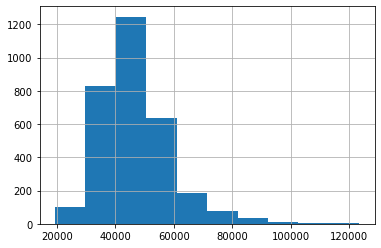

In [15]:
fulldf['Med_Income'].hist()

<AxesSubplot:>

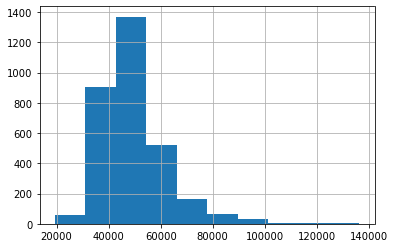

In [16]:
fulldf['Med_Income_White'].hist()

In [17]:
fulldf['Med_Income'] = fulldf.groupby(['State'])['Med_Income'].\
                                transform(lambda x: x.fillna(x.median()))

In [18]:
fulldf['Med_Income_White'] = fulldf.groupby(['State'])['Med_Income_White'].\
                                transform(lambda x: x.fillna(x.median()))

### 1.3 Check the format of columns [5 Marks]
Report the format of each column. List the columns that are in an unexpected format and state why you think that is the case.

*Hint*: You can do this by either inspecting the dataframe or by writing a code snippet that tells you what cells cannot be reformatted to the correct format. The Titatinc Jupyter file that we covered in class may also give you some useful ideas.

In [19]:
fulldf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3134 entries, 0 to 3133
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   State              3134 non-null   object 
 1   AreaName           3134 non-null   object 
 2   All_Poverty        3134 non-null   int64  
 3   M_Poverty          3134 non-null   int64  
 4   F_Poverty          3134 non-null   int64  
 5   FIPS               3134 non-null   object 
 6   Med_Income         3134 non-null   float64
 7   Med_Income_White   3134 non-null   float64
 8   M_With             3134 non-null   int64  
 9   M_Without          3134 non-null   int64  
 10  F_With             3134 non-null   int64  
 11  F_Without          3134 non-null   int64  
 12  All_With           3134 non-null   int64  
 13  All_Without        3134 non-null   int64  
 14  Incidence_Rate     3134 non-null   object 
 15  Avg_Ann_Incidence  3134 non-null   object 
 16  Recent_Trend       3134 

In [20]:
fulldf.head()

,State,AreaName,All_Poverty,M_Poverty,F_Poverty,FIPS,Med_Income,Med_Income_White,M_With,M_Without,F_With,F_Without,All_With,All_Without,Incidence_Rate,Avg_Ann_Incidence,Recent_Trend,Mortality_Rate,Avg_Ann_Deaths
0,AK,"Aleutians East Borough, Alaska",553,334,219,02013,61518.0,72639.0,876,1317,566,540,1442,1857,*,3 or fewer,*,*,*
1,AK,"Aleutians West Census Area, Alaska",499,273,226,02016,84306.0,97321.0,2470,769,1707,564,4177,1333,*,3 or fewer,*,*,*
2,AK,"Anchorage Municipality, Alaska",23914,10698,13216,02020,78326.0,87235.0,120747,23245,122426,21393,243173,44638,61.5,131,stable,47.3,96
3,AK,"Bethel Census Area, Alaska",4364,2199,2165,02050,51012.0,92647.0,6396,2708,6627,1774,13023,4482,62.7,6,stable,58.3,5
4,AK,"Bristol Bay Borough, Alaska",69,33,36,02060,79750.0,88000.0,419,124,349,67,768,191,*,3 or fewer,*,*,*


### 1.4 Merge the population data to the main dataframe [5 Marks]
You already know about FIPS. You can use the state and county columns in this dataset to construct a FIPS column in the population dataframe in the same format as the main dataframe. Then merge the population data to the main dataframe. It is up to you to decide the type of merge and whether it is done properly.

#### There are 4 columns that currently are tagged as an object type, but are actually numerical values, one of which is the response variable. 
1. Incidence_Rate
2. Avg_Ann_Incidence
3. Recent Trend
4. Mortality_Rate (Response variable)
5. Avg_Ann_Deaths

All these columns have character symbols such as *,_, __ along with numerical values which is why these columns have been tagged as object datatype. Columns such as Avg_Ann_Incidence, Incidence Rate have values like '3 or fewer' and '#' along with numberical values as well. 

In [21]:
fulldf['State_Code'] = fulldf['FIPS'].apply(lambda x : x[:2])
fulldf['County_Code'] = fulldf['FIPS'].apply(lambda x : x[2:])

In [22]:
fulldf.head()

,State,AreaName,All_Poverty,M_Poverty,F_Poverty,FIPS,Med_Income,Med_Income_White,M_With,M_Without,...,F_Without,All_With,All_Without,Incidence_Rate,Avg_Ann_Incidence,Recent_Trend,Mortality_Rate,Avg_Ann_Deaths,State_Code,County_Code
0,AK,"Aleutians East Borough, Alaska",553,334,219,02013,61518.0,72639.0,876,1317,...,540,1442,1857,*,3 or fewer,*,*,*,02,013
1,AK,"Aleutians West Census Area, Alaska",499,273,226,02016,84306.0,97321.0,2470,769,...,564,4177,1333,*,3 or fewer,*,*,*,02,016
2,AK,"Anchorage Municipality, Alaska",23914,10698,13216,02020,78326.0,87235.0,120747,23245,...,21393,243173,44638,61.5,131,stable,47.3,96,02,020
3,AK,"Bethel Census Area, Alaska",4364,2199,2165,02050,51012.0,92647.0,6396,2708,...,1774,13023,4482,62.7,6,stable,58.3,5,02,050
4,AK,"Bristol Bay Borough, Alaska",69,33,36,02060,79750.0,88000.0,419,124,...,67,768,191,*,3 or fewer,*,*,*,02,060


In [23]:
populationdf.head()

,POPESTIMATE2015,STATE,COUNTY
0,4858979,1,0
1,55347,1,1
2,203709,1,3
3,26489,1,5
4,22583,1,7


In [24]:
populationdf['STATE'] = populationdf['STATE'].astype(str)
populationdf['STATE'] = populationdf['STATE'].str.pad(width=2, side='left', fillchar='0')

populationdf['COUNTY'] = populationdf['COUNTY'].astype(str)
populationdf['COUNTY'] = populationdf['COUNTY'].str.pad(width=3, side='left', fillchar='0')

In [25]:
fulldf = fulldf.merge(populationdf, left_on=['State_Code', 'County_Code'], \
                              right_on=['STATE', 'COUNTY'], how = 'left')

In [26]:
fulldf = fulldf.drop(columns=['STATE', 'COUNTY'], axis = 1)
fulldf.shape

(3134, 22)

In [27]:
fulldf.head()

,State,AreaName,All_Poverty,M_Poverty,F_Poverty,FIPS,Med_Income,Med_Income_White,M_With,M_Without,...,All_With,All_Without,Incidence_Rate,Avg_Ann_Incidence,Recent_Trend,Mortality_Rate,Avg_Ann_Deaths,State_Code,County_Code,POPESTIMATE2015
0,AK,"Aleutians East Borough, Alaska",553,334,219,02013,61518.0,72639.0,876,1317,...,1442,1857,*,3 or fewer,*,*,*,02,013,3341
1,AK,"Aleutians West Census Area, Alaska",499,273,226,02016,84306.0,97321.0,2470,769,...,4177,1333,*,3 or fewer,*,*,*,02,016,5702
2,AK,"Anchorage Municipality, Alaska",23914,10698,13216,02020,78326.0,87235.0,120747,23245,...,243173,44638,61.5,131,stable,47.3,96,02,020,298695
3,AK,"Bethel Census Area, Alaska",4364,2199,2165,02050,51012.0,92647.0,6396,2708,...,13023,4482,62.7,6,stable,58.3,5,02,050,17946
4,AK,"Bristol Bay Borough, Alaska",69,33,36,02060,79750.0,88000.0,419,124,...,768,191,*,3 or fewer,*,*,*,02,060,892


### 1.5 Cleaning the output (response) column `Mortality_Rate` [10 Marks]
Using the file `descriptions.csv`, explain what the non-numerical values of `Mortality_Rate` mean. 

Then, it is decision making time, we have to decide whether to remove the non-numerical values from `Mortality_Rate` or to assign a specific numerical value to them. This decision is based on you inferring if the non-numerical values were caused by error in data gathering or not. 

Note that if the observations are valid and are deleted, we are adding a bias to the model.

*Hint*: To get the full mark for this part, conduct multiple relevant exploratory data analyses. Then use them to support your decision on removing or modifying the non-numerical values. Your choice results in full mark if the supporting analysis and arguments are deemed adequate and convincing.

In [28]:
data_dict[data_dict['Feature'] == 'Mortality_Rate']

,Unnamed: 0,Feature,Definition,Notes
21,21,Mortality_Rate,"Lung cancer mortality rate (per 100,000)",'*' = fewer that 16 reported cases


The only non-numerical value in Mortality_Rate is '*', meaning fewer than 16 reported cases per 100,000 people 

We first found out the total number of * rows in the mortality column(325) and then removed all these 325 rows. Running a histogram revealed a normal distribution plot for mortality rate & very high r sqaured values for the different models we ran. However, removing the 325 rows meant introducing some form of bias by not considering counties with <16 reported cases at all which could prove to be problematic in the future. We then tried to create a logic that estimates values for these * values instead.

### Current Approach to Clean Column: 

1. We wanted to make sure we consider only those states which have significant counties with * values. States which have a a very small % of their total counties with * values could be due to error or may not be as significant as part of the prediction model (For ex states with 120 counties overall but only 1/2 counties with stars). To tackle this we calculated a w_stars % of each state. 

2. Next, we took just the top 10 quartile of w_stars% column and eliminated the remianing 90% of the data. This gave us top 5 states (~ 1/3rd of missing data) with the highest counties containing * values for the mortality rate. 

3. We then estimated the missing values by 
      - splitting these top 5 states by counties with stars & without stars and calculating the median population of the 2         respective buckets. The reason for choosing the median is because the normal distribution is skewed, so using mean         would introduce bias. 
      - Next, we calculated the median mortality rate of counties without stars and divided it by the median population             calculated to get to a rate_of_death ratio for each of the Top 5 states
      - Finally, we substitued the stars in our main dataframe by multiplying this factor by the population of the county           with stars in the same state.

In [29]:
fulldf.loc[fulldf['Mortality_Rate'] == '*', 'star_vs_non_star'] = 'star'
fulldf.loc[fulldf['Mortality_Rate'] != '*', 'star_vs_non_star'] = 'non_star'

In [30]:
no_of_counties = fulldf.groupby('State')['AreaName'].nunique().reset_index().\
        rename(columns = {'AreaName' : 'no_of_counties'})

no_of_counties_w_stars = fulldf[fulldf['star_vs_non_star'] == 'star'].groupby('State')['AreaName'].nunique().reset_index().\
        rename(columns = {'AreaName' : 'no_of_counties_w_stars'})

no_of_counties_wo_stars = fulldf[fulldf['star_vs_non_star'] != 'star'].groupby('State')['AreaName'].nunique().reset_index().\
        rename(columns = {'AreaName' : 'no_of_counties_wo_stars'})


In [31]:
no_of_counties = no_of_counties.merge(no_of_counties_w_stars, on = 'State', how = 'left')
no_of_counties = no_of_counties.merge(no_of_counties_wo_stars, on = 'State', how = 'left')

In [32]:
no_of_counties.sum()

State                      AKALARAZCACOCTDCDEFLGAHIIAIDILINKSKYLAMAMDMEMI...
no_of_counties                                                          3134
no_of_counties_w_stars                                                 325.0
no_of_counties_wo_stars                                                 2809
dtype: object

In [33]:
no_of_counties.sort_values(by = 'no_of_counties_w_stars', ascending=False, inplace=True)

In [34]:
no_of_counties['no_of_counties_w_stars'] = no_of_counties['no_of_counties_w_stars'].fillna(0)

In [35]:
no_of_counties['w_stars_%'] = round((no_of_counties['no_of_counties_w_stars'] /\
                                no_of_counties['no_of_counties'])*100, 2)

In [36]:
no_of_counties.sort_values(by = 'w_stars_%', ascending=False, inplace=True)

In [37]:
no_of_counties

,State,no_of_counties,no_of_counties_w_stars,no_of_counties_wo_stars,w_stars_%
28,ND,53,30.0,23,56.60
0,AK,23,11.0,12,47.83
41,SD,65,31.0,34,47.69
44,UT,29,12.0,17,41.38
29,NE,93,37.0,56,39.78
5,CO,64,24.0,40,37.50
26,MT,56,21.0,35,37.50
16,KS,105,36.0,69,34.29
13,ID,44,15.0,29,34.09
33,NV,17,5.0,12,29.41


In [38]:
countries_in_top_25 = list(no_of_counties[no_of_counties['w_stars_%'] >\
                    no_of_counties['w_stars_%'].quantile(0.90)]['State'].unique())

countries_in_top_25

['ND', 'AK', 'SD', 'UT', 'NE']

In [39]:
w_stars_pops = fulldf[(fulldf['State'].isin(countries_in_top_25)) &\
              (fulldf['star_vs_non_star'] == 'star')].\
                        groupby('State').agg({'POPESTIMATE2015' : 'median'}).reset_index().\
                            rename(columns = {'POPESTIMATE2015' : 'pops_w_stars'})

w_stars_pops

,State,pops_w_stars
0,AK,3341.0
1,ND,2637.5
2,NE,2006.0
3,SD,2803.0
4,UT,6742.5


In [40]:
wo_stars_df = fulldf[fulldf['star_vs_non_star'] == 'non_star']
wo_stars_df['Mortality_Rate'] = wo_stars_df['Mortality_Rate'].astype(float)

wo_stars_pops = wo_stars_df[(wo_stars_df['State'].isin(countries_in_top_25)) &\
              (fulldf['star_vs_non_star'] == 'non_star')].\
                        groupby('State')[['POPESTIMATE2015', 'Mortality_Rate']].median().reset_index()

wo_stars_pops

C:\Users\Tanishqa Agarwal\AppData\Local\Temp\ipykernel_11128\1196269186.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wo_stars_df['Mortality_Rate'] = wo_stars_df['Mortality_Rate'].astype(float)
C:\Users\Tanishqa Agarwal\AppData\Local\Temp\ipykernel_11128\1196269186.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  wo_stars_pops = wo_stars_df[(wo_stars_df['State'].isin(countries_in_top_25)) &\


,State,POPESTIMATE2015,Mortality_Rate
0,AK,15917.5,56.15
1,ND,11099.0,42.80
2,NE,9243.0,43.70
3,SD,10121.0,44.85
4,UT,48368.0,22.10


In [41]:
wo_stars_pops['rate_of_death'] = wo_stars_pops['Mortality_Rate'] / wo_stars_pops['POPESTIMATE2015']

In [42]:
merged = wo_stars_pops.merge(w_stars_pops, on = 'State', how = 'left')
merged

,State,POPESTIMATE2015,Mortality_Rate,rate_of_death,pops_w_stars
0,AK,15917.5,56.15,0.003528,3341.0
1,ND,11099.0,42.80,0.003856,2637.5
2,NE,9243.0,43.70,0.004728,2006.0
3,SD,10121.0,44.85,0.004431,2803.0
4,UT,48368.0,22.10,0.000457,6742.5


In [43]:
merged_2 = fulldf.merge(merged[['State', 'rate_of_death']], on = 'State', how = 'left')

In [44]:
merged_2.head()

,State,AreaName,All_Poverty,M_Poverty,F_Poverty,FIPS,Med_Income,Med_Income_White,M_With,M_Without,...,Incidence_Rate,Avg_Ann_Incidence,Recent_Trend,Mortality_Rate,Avg_Ann_Deaths,State_Code,County_Code,POPESTIMATE2015,star_vs_non_star,rate_of_death
0,AK,"Aleutians East Borough, Alaska",553,334,219,02013,61518.0,72639.0,876,1317,...,*,3 or fewer,*,*,*,02,013,3341,star,0.003528
1,AK,"Aleutians West Census Area, Alaska",499,273,226,02016,84306.0,97321.0,2470,769,...,*,3 or fewer,*,*,*,02,016,5702,star,0.003528
2,AK,"Anchorage Municipality, Alaska",23914,10698,13216,02020,78326.0,87235.0,120747,23245,...,61.5,131,stable,47.3,96,02,020,298695,non_star,0.003528
3,AK,"Bethel Census Area, Alaska",4364,2199,2165,02050,51012.0,92647.0,6396,2708,...,62.7,6,stable,58.3,5,02,050,17946,non_star,0.003528
4,AK,"Bristol Bay Borough, Alaska",69,33,36,02060,79750.0,88000.0,419,124,...,*,3 or fewer,*,*,*,02,060,892,star,0.003528


In [45]:
merged_2.loc[merged_2['star_vs_non_star'] == 'star', 'Mortality_Rate'] = merged_2['rate_of_death'] *\
                    merged_2['POPESTIMATE2015']

In [46]:
merged_2.head()

,State,AreaName,All_Poverty,M_Poverty,F_Poverty,FIPS,Med_Income,Med_Income_White,M_With,M_Without,...,Incidence_Rate,Avg_Ann_Incidence,Recent_Trend,Mortality_Rate,Avg_Ann_Deaths,State_Code,County_Code,POPESTIMATE2015,star_vs_non_star,rate_of_death
0,AK,"Aleutians East Borough, Alaska",553,334,219,02013,61518.0,72639.0,876,1317,...,*,3 or fewer,*,11.785591,*,02,013,3341,star,0.003528
1,AK,"Aleutians West Census Area, Alaska",499,273,226,02016,84306.0,97321.0,2470,769,...,*,3 or fewer,*,20.11417,*,02,016,5702,star,0.003528
2,AK,"Anchorage Municipality, Alaska",23914,10698,13216,02020,78326.0,87235.0,120747,23245,...,61.5,131,stable,47.3,96,02,020,298695,non_star,0.003528
3,AK,"Bethel Census Area, Alaska",4364,2199,2165,02050,51012.0,92647.0,6396,2708,...,62.7,6,stable,58.3,5,02,050,17946,non_star,0.003528
4,AK,"Bristol Bay Borough, Alaska",69,33,36,02060,79750.0,88000.0,419,124,...,*,3 or fewer,*,3.146587,*,02,060,892,star,0.003528


In [47]:
merged_2['Mortality_Rate'].unique()

array([11.785591330296842, 20.114169938746663, '47.3', '58.3',
       3.1465870896811685, 6.769395319616774, 17.627237317417936, '54',
       8.938847180775875, '34.4', '50.1', '70.8', '76.2',
       5.513582534945814, '53.9', '96.1', '124.9', 27.345676142610333,
       '39.6', 24.125010208889588, '60.8', 2.162396733155332,
       19.518011622428144, '59.3', '48', '61.3', '67.8', '59.9', '29.7',
       '52.6', '63.1', '66', '43', '43.9', '69.1', '59.7', '55.1', '61.2',
       '60.2', '68.9', '71.9', '61.4', '63.6', '65.3', '56.3', '66.1',
       '67', '67.7', '65.8', '71.2', '34.5', '57.8', '56.1', '64', '51.5',
       '72.2', '56.8', '70', '57.1', '55.9', '44', '41.1', '50.4', '51.9',
       '51.7', '66.6', '63.3', '52.9', '49.9', '60.5', '60.3', '57.5',
       '47.2', '58.5', '65', '51', '61', '54.5', '54.4', '79.8', '61.7',
       '69.9', '58.6', '64.3', '47', '62.6', '68.3', '70.2', '47.7',
       '53.3', '80.1', '70.5', '49.2', '61.8', '75.7', '74', '62.8',
       '66.9', '70.1', 

In [48]:
merged_2[merged_2['Mortality_Rate'] == '*'].shape

(0, 24)

In [49]:
merged_2[merged_2['Mortality_Rate'].isna()].shape

(204, 24)

In [50]:
merged_2 = merged_2[~merged_2['Mortality_Rate'].isna()]

In [51]:
merged_2['Mortality_Rate'] = merged_2['Mortality_Rate'].astype(float)

<AxesSubplot:>

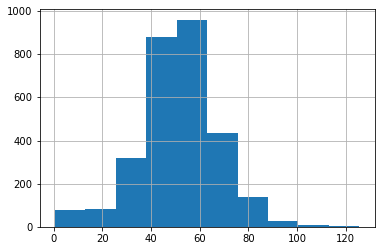

In [52]:
merged_2['Mortality_Rate'].hist()

In [53]:
fulldf = merged_2.copy()

### 1.6 Reformat the rest of the columns specified in 1.3 to numerical [5 Marks]
In each column reformat all the cells that you can. 

*Hint*: You can keep the cells that you cannot reformat until you decide if you want to use the specific column in the model. This is because you want to lose as least data as possible. So you can drop the associated rows if you want to use the column and keep them if the specific column is not used.

#### As discussed before in 1.3, following are the columns that need to be reformatted,
1. Incidence_Rate (should be numerical)
2. Avg_Ann_Incidence (should be numerical)
3. Recent Trend (should be categorical)
4. Avg_Ann_Deaths (should be numerical)

They have characters like *, _ or __ in some cells as their values. So will be replace them with NaNs and check how many values are missing.

### Approach: Avg_Ann_Incidence

For the Avg_Ann_Incidence column, wherever we have _ or __, the corresponding values for Incidence_Rate and Recent_Trend columns are also missing. Moreover, they appear for only 3 states - KS, MN and NV, for which all the data for these 3 columns are missing. So we will simply drop these rows (which makes up for 6.59% of the data). We wont drop the columns as being continuous vars, they might play an important role in our modelling process.

In [54]:
fulldf[fulldf['Avg_Ann_Incidence'].isin(['_', '__'])].shape

(163, 24)

In [55]:
fulldf.shape

(2930, 24)

In [56]:
204/3095*100

6.591276252019386

In [57]:
fulldf[fulldf['Avg_Ann_Incidence'].isin(['_', '__'])]['State'].unique()

array(['KS', 'MN', 'NV'], dtype=object)

In [58]:
fulldf = fulldf[~(fulldf['Avg_Ann_Incidence'].isin(['_', '__']))]
fulldf.shape

(2767, 24)

### Approach: Incidence Rate

We see that the numerical values in the <b> Incidence_Rate </b> column follow a normal distribution, hence we can replace the non-numerical values with either <i> mean </i> or <i> median </i> . We see that the distribution follows a bell-curve but it is right-skewed. Since it is right-skewed, taking the mean implies that the mean is skewed by a few large values. Hence, we replace the non-numeric values (*, _ and __ ) with the median of the numeric values

<AxesSubplot:>

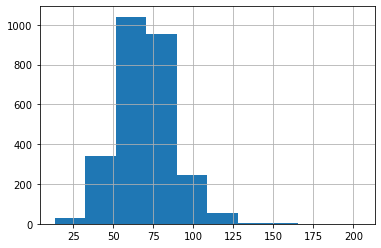

In [59]:
fulldf['Incidence_Rate'] = fulldf['Incidence_Rate'].str.replace(' #', '')
fulldf.loc[fulldf['Incidence_Rate'] == '*', 'Incidence_Rate'] = '0'
fulldf['Incidence_Rate'] = fulldf['Incidence_Rate'].astype(float)
fulldf.loc[fulldf['Incidence_Rate'] == 0.0, 'Incidence_Rate'] = np.NaN

fulldf['Incidence_Rate'].hist()

In [60]:
fulldf['Incidence_Rate'] = fulldf.groupby(['State'])['Incidence_Rate'].\
                                transform(lambda x: x.fillna(x.median()))

### Approach: Avg_Ann_Deaths

We see that the numerical values in Avg_Ann_Deaths column are extremely left skewed and hence we will replace the * values in this column by the median value of Avg_Ann_Deaths of the state the county belongs to. 

In [61]:
# fulldf['Avg_Ann_Deaths'].hist()

In [62]:
fulldf['Avg_Ann_Deaths'] = fulldf['Avg_Ann_Deaths'].str.replace(',', '')

fulldf.loc[fulldf['Avg_Ann_Deaths'] == '*', 'Avg_Ann_Deaths'] = '0'

fulldf['Avg_Ann_Deaths'] = fulldf['Avg_Ann_Deaths'].astype(float)

fulldf.loc[fulldf['Avg_Ann_Deaths'] == 0.0, 'Avg_Ann_Deaths'] = np.NaN

fulldf['Avg_Ann_Deaths'] = fulldf.groupby(['State'])['Avg_Ann_Deaths'].\
                                transform(lambda x: x.fillna(x.median()))

### Approach: Avg_Ann_Incidence 

The Avg_Ann_Incidence column has values '3 or fewer' which we replaced with 3 to not be very conservative. 



In [63]:
fulldf.loc[fulldf['Avg_Ann_Incidence'] == '3 or fewer', 'Avg_Ann_Incidence'] = '3'

fulldf['Avg_Ann_Incidence'] = fulldf['Avg_Ann_Incidence'].astype(float)

In the above process, we have reformatted Incidence_Rate, Avg_Ann_Incidence and Avg_Ann_Deaths to the right format. We did this by projecting the * values with median values of the respective columns after grouping by State, so essentially all the * values will be filled by median values of the grouped State it belongs to.

### Approach: Recent_Trend

Recent Trend is a categorical variable and hence to fill missing values for this column we substituted the * and _ values by the category with the highest mode. In this case it being 'stable'

In [64]:
fulldf['Recent_Trend'].unique()

array(['*', 'stable', 'falling', 'rising'], dtype=object)

In [65]:
fulldf['Recent_Trend'].value_counts()

stable     2397
falling     198
*           132
rising       40
Name: Recent_Trend, dtype: int64

In [66]:
fulldf.loc[fulldf['Recent_Trend'] == '*', 'Recent_Trend'] = 'stable'

In [67]:
fulldf['Recent_Trend'].value_counts()

stable     2529
falling     198
rising       40
Name: Recent_Trend, dtype: int64

### 1.7 Make the numerical data useful [5 Marks]
We know we have many columns of data, some of them are dependent on the populations. As a *Hint*, convert all the raw data to per 100,000 persons rates (divide by population and multiply by 100,000).

Except for the Mortality Rate & Incidence Rate columns, all other numeric columns are in raw data format. And hence to make them useful as well we have selected all columns related to poverty and Insurance to make them easily comparable to the response variable. 

In [68]:
for col in ['All_Poverty', 'M_Poverty', 'F_Poverty','M_With', 'M_Without', 'F_With',
       'F_Without', 'All_With', 'All_Without']:
            
    fulldf[col] = fulldf[col] / fulldf['POPESTIMATE2015'] * 100000

## **Part 2: Exploratory analysis [15 Marks]**

### 2.1 Visualizing different features [5 Marks]
Here, show different feature and how they change with respect to each other.
*Hint*: A good function to use here is `sns.pairplot`. Remember to have the plots labeled properly so that they are self explanatory.


#### We first check the distribution of response variable (Mortality Rate)

C:\Users\Tanishqa Agarwal\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


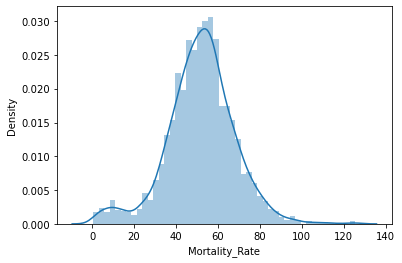

In [69]:
sns.distplot(fulldf['Mortality_Rate'])
plt.show()

The data looks normally distributed for the most part, except for another small peak occuring between 0 to 20. This is mainly due to the estimation of mortality rate we have done for the '*' values. 

To select the most important features for modelling (for the next sub-section), we will first make a correlation matrix that will help us identify all the highly correlated features, and get rid of them for the modelling process. 

<AxesSubplot:>

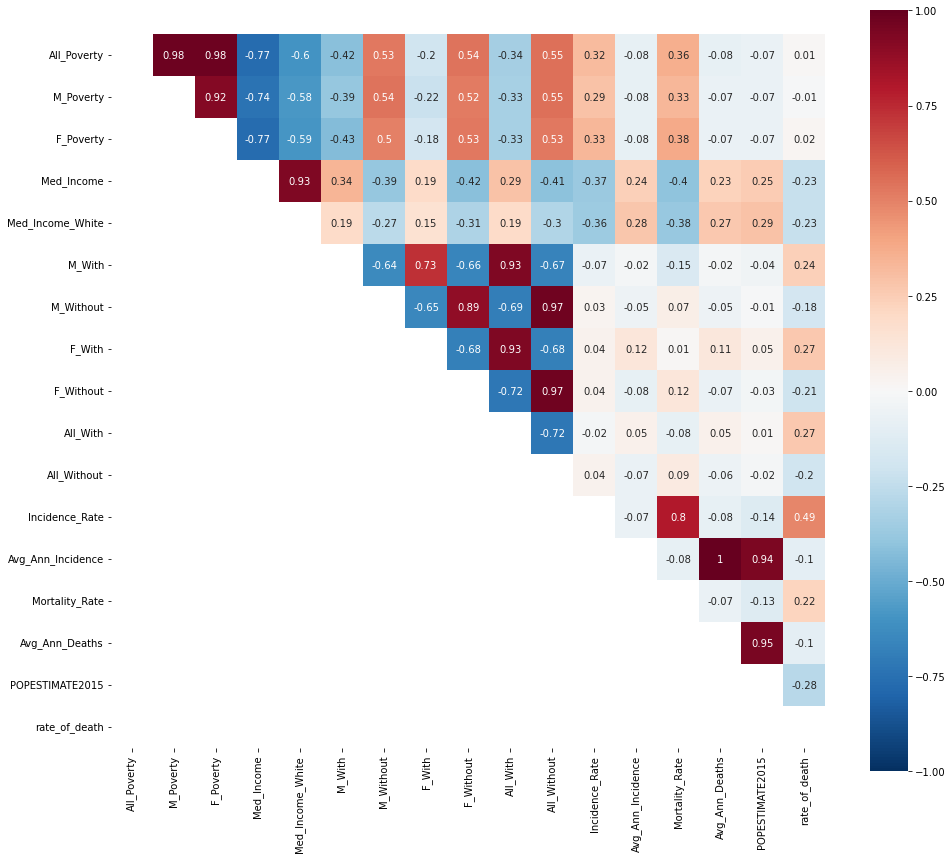

In [70]:
# heatmap with all the columns
plt.figure(figsize = (16,14))
matrix = np.triu(fulldf.corr())
sns.heatmap(fulldf.corr().round(2), square =True, annot=True, cmap='RdBu_r', mask=np.flip(matrix), vmin=-1, vmax=1)

In [71]:
matrix = fulldf.corr().abs()
high_corr_var = np.where(matrix > 0.8)
high_corr_var = [(matrix.columns[x],matrix.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]

In [72]:
high_corr_var

[('All_Poverty', 'M_Poverty'),
 ('All_Poverty', 'F_Poverty'),
 ('M_Poverty', 'F_Poverty'),
 ('Med_Income', 'Med_Income_White'),
 ('M_With', 'All_With'),
 ('M_Without', 'F_Without'),
 ('M_Without', 'All_Without'),
 ('F_With', 'All_With'),
 ('F_Without', 'All_Without'),
 ('Avg_Ann_Incidence', 'Avg_Ann_Deaths'),
 ('Avg_Ann_Incidence', 'POPESTIMATE2015'),
 ('Avg_Ann_Deaths', 'POPESTIMATE2015')]

Above columns have a correlation value higher than 0.8 (absolute value). As a result, we will remove one column from each pair.

In [73]:
cols_to_remove = ['M_Poverty', 'F_Poverty', 'Med_Income_White', 'M_With', 'F_With',\
                     'M_Without', 'F_Without', 'Avg_Ann_Incidence', 'Avg_Ann_Deaths', 'POPESTIMATE2015']

test = fulldf.drop(columns=cols_to_remove, axis = 1)

test.shape

(2767, 14)

<AxesSubplot:>

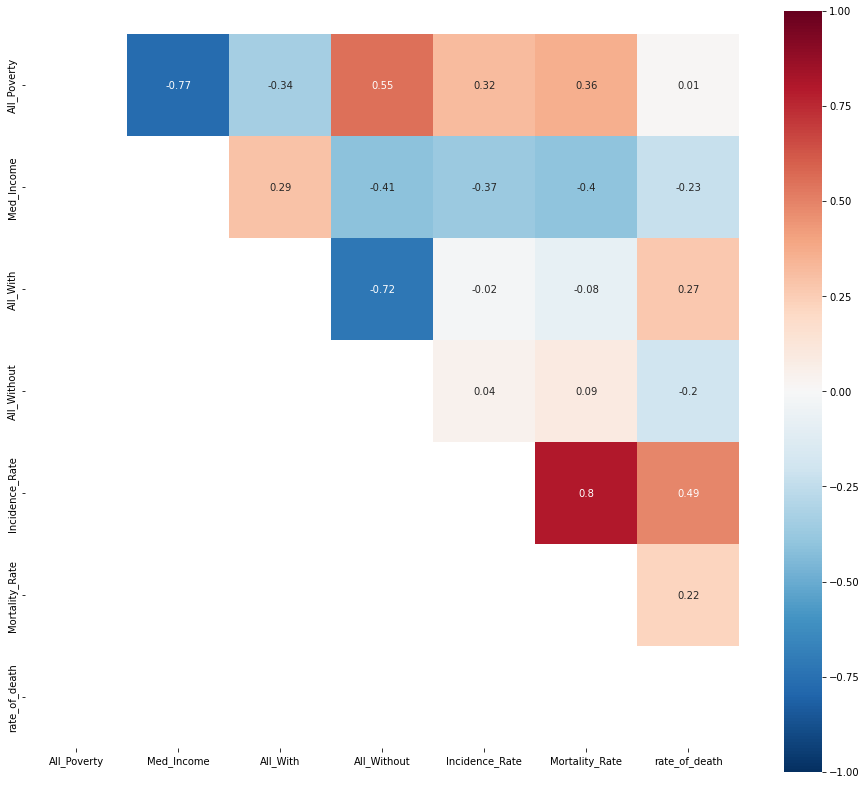

In [74]:
# Correlation heatmap with all relevant columns
plt.figure(figsize = (16,14))
matrix = np.triu(test.corr())
sns.heatmap(test.corr().round(2), square =True, annot=True, cmap='RdBu_r', mask=np.flip(matrix), vmin=-1, vmax=1)

Now that we have a more refined subset, we can make the pairplot below to make sense of the data distributions we have.

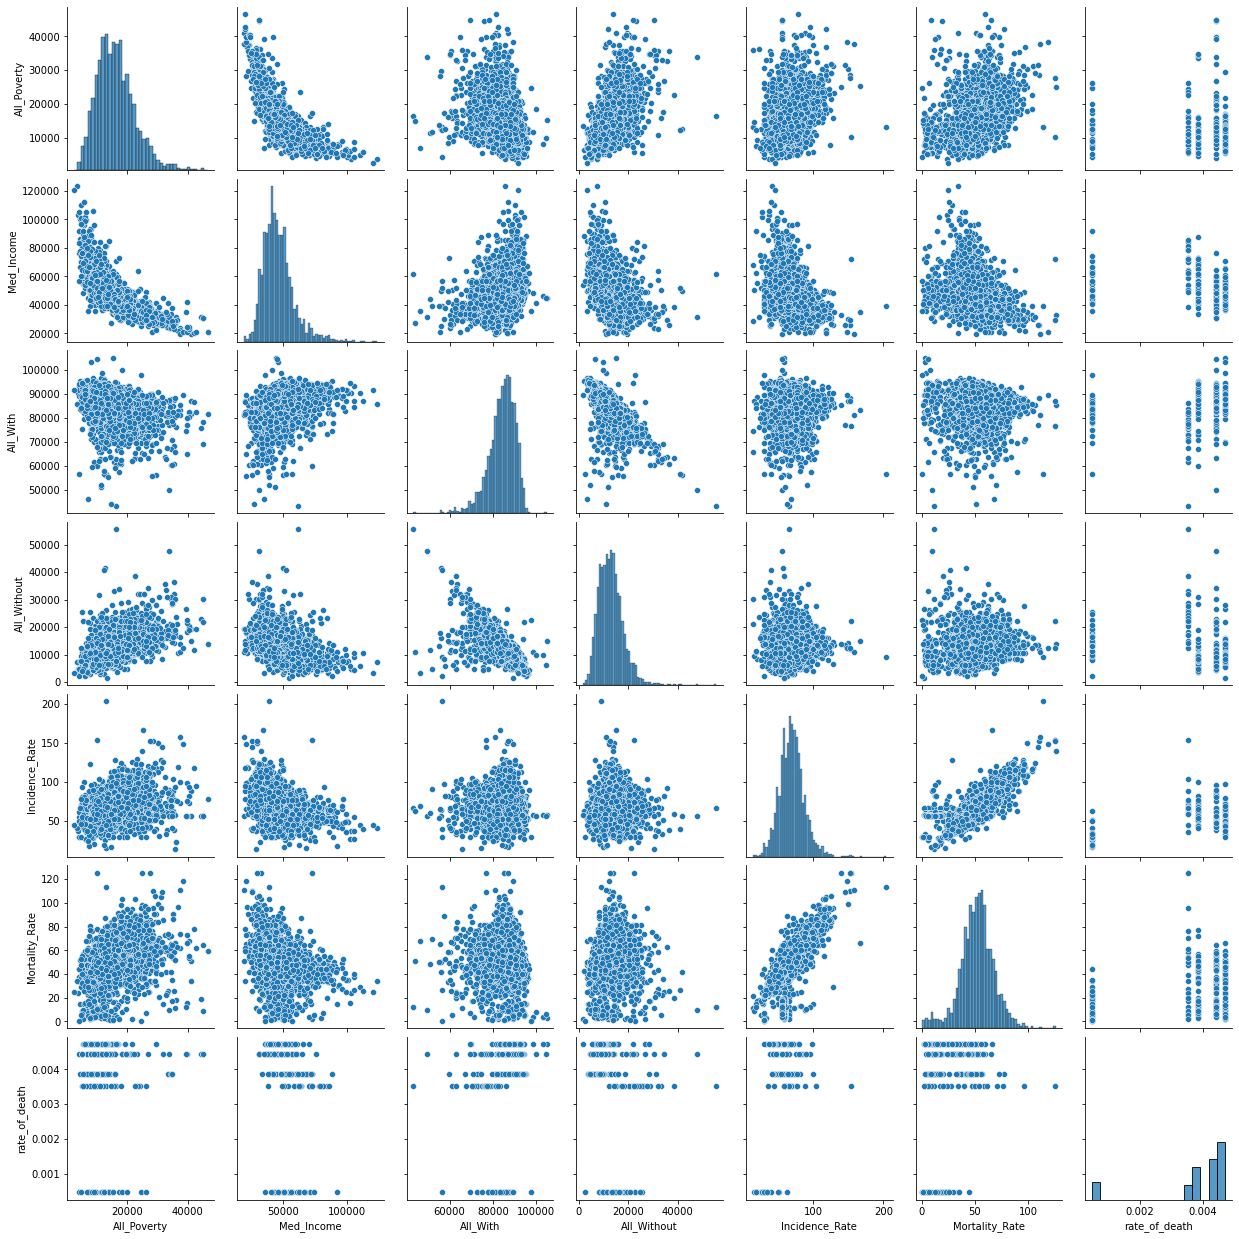

In [75]:
sns.pairplot(test)

### 2.2 Selecting the most important features [10 Marks]
In this step, we want to remove the redundant features. 

*Hint*: This can be done by analyzing the correlation between the features and removing the highly correlated features. Remember, throughout the project, write down specific reasons for any desicion you make.

#### In the above sub-section, we made a correlation matrix to figure out the most important features that can be used in our model. Here, we have stated those chosen columns.

<b> Selected features
- All_Poverty : This feature seemed to be highly correlated with M_Poverty and F_Poverty (summation of which gives us All_Poverty). So we have removed these two features and kept All_Poverty.
- Med_Income: It was highly correlated with Med_Income_White, and thus we removed it and kept Med_Income.
- Incidence_Rate: This seems to be a very important feature as it is highy correlated with Mortality_Rate (check the above correlation matrix and pairplot to see their positive linear relationship).
- Avg_Ann_Deaths: This feature had a high correlation with Avg_Ann_Incidence.
- All_With : This feature seemed to be highly correlated with M_With and F_With (summation of which gives us All_With). So we have removed these two features and kept All_With.
- Recent Trend : We will keep this column and create its dummy variables, and check later on if its a useful feature when performing Random Forest Feature Selection.

In [76]:
test.columns

Index(['State', 'AreaName', 'All_Poverty', 'FIPS', 'Med_Income', 'All_With',
       'All_Without', 'Incidence_Rate', 'Recent_Trend', 'Mortality_Rate',
       'State_Code', 'County_Code', 'star_vs_non_star', 'rate_of_death'],
      dtype='object')

In [77]:
features = ['All_Poverty', 'Med_Income', 'All_With',
       'All_Without', 'Incidence_Rate', 'Mortality_Rate', 'Recent_Trend', 'State']

final_df = fulldf[features]

final_df.shape

(2767, 8)

One extra step before going forward with modelling : Creating dummy variables for Recent_Trend & State columns as these are categorical variables and cannot be used as is in the regression model

In [78]:
final_df.dtypes

All_Poverty       float64
Med_Income        float64
All_With          float64
All_Without       float64
Incidence_Rate    float64
Mortality_Rate    float64
Recent_Trend       object
State              object
dtype: object

In [79]:
x = fulldf[features]
input_data = x

In [80]:
categorical_cols = ['State']
if len(categorical_cols) != 0 :
    cat_data = pd.get_dummies(input_data[categorical_cols],dtype= float)
    input_data= pd.concat([input_data.reset_index(drop= True), cat_data.reset_index(drop = True)], axis = 1)
    input_data = input_data.drop(categorical_cols, axis = 1)

In [81]:
input_data.columns

Index(['All_Poverty', 'Med_Income', 'All_With', 'All_Without',
       'Incidence_Rate', 'Mortality_Rate', 'Recent_Trend', 'State_AK',
       'State_AL', 'State_AR', 'State_AZ', 'State_CA', 'State_CO', 'State_CT',
       'State_DC', 'State_DE', 'State_FL', 'State_GA', 'State_HI', 'State_IA',
       'State_ID', 'State_IL', 'State_IN', 'State_KY', 'State_LA', 'State_MA',
       'State_MD', 'State_ME', 'State_MI', 'State_MO', 'State_MS', 'State_MT',
       'State_NC', 'State_ND', 'State_NE', 'State_NH', 'State_NJ', 'State_NM',
       'State_NY', 'State_OH', 'State_OK', 'State_OR', 'State_PA', 'State_RI',
       'State_SC', 'State_SD', 'State_TN', 'State_TX', 'State_UT', 'State_VA',
       'State_VT', 'State_WA', 'State_WI', 'State_WV', 'State_WY'],
      dtype='object')

In [82]:
categorical_cols = ['Recent_Trend']
if len(categorical_cols) != 0 :
    cat_data = pd.get_dummies(input_data[categorical_cols],dtype= float)
    input_data= pd.concat([input_data.reset_index(drop= True), cat_data.reset_index(drop = True)], axis = 1)
    input_data = input_data.drop(categorical_cols, axis = 1)

In [83]:
input_data.head()

,All_Poverty,Med_Income,All_With,All_Without,Incidence_Rate,Mortality_Rate,State_AK,State_AL,State_AR,State_AZ,...,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY,Recent_Trend_falling,Recent_Trend_rising,Recent_Trend_stable
0,16551.930560,61518.0,43160.730320,55582.161030,66.1,11.785591,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,8751.315328,84306.0,73254.998246,23377.762189,66.1,20.114170,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,8006.160130,78326.0,81411.808032,14944.341218,61.5,47.300000,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,24317.396634,51012.0,72567.703109,24974.924774,62.7,58.300000,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,7735.426009,79750.0,86098.654709,21412.556054,66.1,3.146587,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## **Part 3: Regression Model Construction [30 Marks]**

### 3.1 Splitting the dataset [5 Marks] 

Split the dataset to three parts: train, validation, and test. You choose the ratios for the three datasets and provide a one-sentence rationale on why you went with such ratios.

*Hint*: You can use the validation set approach from ch5 lab (google colab).

### Data Split 

The data we have is split into 3 parts - training set, validation set and testing set. 

- 90% of the data will be used for training and validating the model.
- 10% of the data will be used for testing the model.

In [84]:
input_data.columns

Index(['All_Poverty', 'Med_Income', 'All_With', 'All_Without',
       'Incidence_Rate', 'Mortality_Rate', 'State_AK', 'State_AL', 'State_AR',
       'State_AZ', 'State_CA', 'State_CO', 'State_CT', 'State_DC', 'State_DE',
       'State_FL', 'State_GA', 'State_HI', 'State_IA', 'State_ID', 'State_IL',
       'State_IN', 'State_KY', 'State_LA', 'State_MA', 'State_MD', 'State_ME',
       'State_MI', 'State_MO', 'State_MS', 'State_MT', 'State_NC', 'State_ND',
       'State_NE', 'State_NH', 'State_NJ', 'State_NM', 'State_NY', 'State_OH',
       'State_OK', 'State_OR', 'State_PA', 'State_RI', 'State_SC', 'State_SD',
       'State_TN', 'State_TX', 'State_UT', 'State_VA', 'State_VT', 'State_WA',
       'State_WI', 'State_WV', 'State_WY', 'Recent_Trend_falling',
       'Recent_Trend_rising', 'Recent_Trend_stable'],
      dtype='object')

In [85]:
from sklearn.model_selection import train_test_split

seed = 500

X_data = input_data[['All_Poverty', 'Med_Income',
       'Incidence_Rate', 'State_AK', 'State_AL', 'State_AR',
       'State_AZ', 'State_CA', 'State_CO', 'State_CT', 'State_DC', 'State_DE',
       'State_FL', 'State_GA', 'State_HI', 'State_IA', 'State_ID', 'State_IL',
       'State_IN', 'State_KY', 'State_LA', 'State_MA', 'State_MD', 'State_ME',
       'State_MI', 'State_MO', 'State_MS', 'State_MT', 'State_NC', 'State_ND',
       'State_NE', 'State_NH', 'State_NJ', 'State_NM', 'State_NY', 'State_OH',
       'State_OK', 'State_OR', 'State_PA', 'State_RI', 'State_SC', 'State_SD',
       'State_TN', 'State_TX', 'State_UT', 'State_VA', 'State_VT', 'State_WA',
       'State_WI', 'State_WV', 'State_WY']]

y_data = input_data['Mortality_Rate']

# 80% traning set, 10% test set, 10% validation set

X, X_test, y, y_test = train_test_split(X_data, y_data, test_size=0.1, train_size=0.9)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.20,train_size =0.80)


### 3.2 Model training [15 Marks]
Create three different models, using different features (and optionally nonlinear transformations). The purpose of these models is to predict mortality rate of lung cancer with reasonably high R2 (at least exceeding 70%) using a carefully chosen and justified set of features. Use the visualizations from section 2.1 to inform the feature selection for each model.

### Model1 :

In our first model, we are considering all the columns that are important to us after filtering out the highly correlated features. We will then run the Linear Regression Model.

In [783]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import linear_model

regr_1 = linear_model.LinearRegression()
regr_1.fit(X_train,y_train)
y_pred = regr_1.predict(X_val)
print("accuracy: "+ str(regr_1.score(X_val,y_val)*100) + "%")
print("Mean absolute error: {}".format(mean_absolute_error(y_val, y_pred)))
print("Mean squared error: {}".format(mean_squared_error(y_val,y_pred)))
R2 = r2_score(y_val,y_pred)
print('R Squared: {}'.format(R2))
n = X_val.shape[0]
p = X_val.shape[1] - 1

adj_rsquared = 1 - (1 - R2) * ((n - 1)/(n-p-1))
print('Adjusted R Squared: {}'.format(adj_rsquared))

accuracy: 70.96870636890861%
Mean absolute error: 5.697155779264074
Mean squared error: 64.57238549864844
R Squared: 0.7096870636890861
Adjusted R Squared: 0.6772135808802591


##### Using Random Forest Feature Selection to select the best features,

In [695]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)

RandomForestRegressor()

In [696]:
rf.feature_importances_

array([5.92042235e-02, 6.55485411e-02, 7.45307411e-01, 9.28444775e-03,
       1.28982576e-03, 2.15947256e-03, 9.86145787e-05, 2.03611341e-04,
       2.26334946e-04, 1.62161700e-04, 2.54677493e-07, 1.69796295e-06,
       1.18100628e-03, 3.17493699e-03, 1.13151024e-05, 1.46581863e-03,
       5.73535832e-04, 1.17995477e-03, 1.20037395e-03, 1.25030676e-03,
       1.35845455e-03, 8.41290053e-05, 3.14295951e-04, 1.77078069e-04,
       1.88949004e-03, 3.13560988e-03, 2.77805609e-03, 2.05342865e-03,
       1.64682142e-03, 1.98834185e-02, 1.46668102e-02, 3.08269862e-05,
       4.98091694e-05, 3.03334294e-04, 1.03915787e-03, 1.14590433e-03,
       4.30342693e-03, 2.11862733e-04, 4.64667461e-04, 7.22164777e-06,
       3.42507367e-04, 3.30752719e-02, 2.14738260e-03, 2.41547027e-03,
       4.58912274e-03, 5.44706622e-03, 8.02293027e-05, 2.66747011e-04,
       4.56231366e-04, 1.54695639e-03, 5.65365892e-04])

Text(0.5, 0, 'Random Forest Feature Importance')

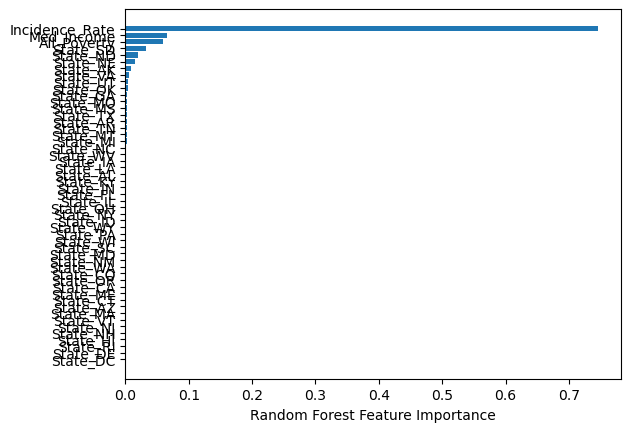

In [697]:
sorted_idx = rf.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [698]:
print(X_train.columns[sorted_idx], rf.feature_importances_[sorted_idx])

Index(['State_DC', 'State_DE', 'State_RI', 'State_HI', 'State_NH', 'State_NJ',
       'State_VT', 'State_MA', 'State_AZ', 'State_CT', 'State_ME', 'State_CA',
       'State_OR', 'State_CO', 'State_WA', 'State_NM', 'State_MD', 'State_SC',
       'State_WI', 'State_PA', 'State_WY', 'State_ID', 'State_NY', 'State_OH',
       'State_IL', 'State_FL', 'State_IN', 'State_KY', 'State_AL', 'State_LA',
       'State_IA', 'State_WV', 'State_NC', 'State_MI', 'State_MT', 'State_TN',
       'State_AR', 'State_TX', 'State_MS', 'State_MO', 'State_GA', 'State_OK',
       'State_UT', 'State_VA', 'State_AK', 'State_NE', 'State_ND', 'State_SD',
       'All_Poverty', 'Med_Income', 'Incidence_Rate'],
      dtype='object') [2.54677493e-07 1.69796295e-06 7.22164777e-06 1.13151024e-05
 3.08269862e-05 4.98091694e-05 8.02293027e-05 8.41290053e-05
 9.86145787e-05 1.62161700e-04 1.77078069e-04 2.03611341e-04
 2.11862733e-04 2.26334946e-04 2.66747011e-04 3.03334294e-04
 3.14295951e-04 3.42507367e-04 4.56231366e-04 4

### Model2 : 

Here, we have picked out the best features given by our Random Forrest Feature Selection model (shown above). This leads us to use only 3 features for our model to predict Mortality_Rate,
1. All_Poverty
2. Med_Income
3. Incidence_Rate

In [777]:
X_data = input_data[['All_Poverty', 'Med_Income',
       'Incidence_Rate']]

y_data = input_data['Mortality_Rate']

# 80% traning set, 10% test set, 10% validation set

X, X_test, y, y_test = train_test_split(X_data, y_data, test_size=0.1, train_size=0.9)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.20,train_size =0.80)


In [778]:
regr_2 = linear_model.LinearRegression()
regr_2.fit(X_train,y_train)
y_pred = regr_2.predict(X_val)
print("accuracy: "+ str(regr_2.score(X_val,y_val)*100) + "%")
print("Mean absolute error: {}".format(mean_absolute_error(y_val, y_pred)))
print("Mean squared error: {}".format(mean_squared_error(y_val,y_pred)))
R2 = r2_score(y_val,y_pred)
print('R Squared: {}'.format(R2))
n = X_val.shape[0]
p = X_val.shape[1] - 1

adj_rsquared = 1 - (1 - R2) * ((n - 1)/(n-p-1))
print('Adjusted R Squared: {}'.format(adj_rsquared))

accuracy: 72.00508556944288%
Mean absolute error: 5.780567951664009
Mean squared error: 74.48534079452003
R Squared: 0.7200508556944288
Adjusted R Squared: 0.7189197480406689


### Model3 : 

In model 3, we are applying a basic log transformation to our Med_Income feature, because we see its data being a bit left-skewed. Applying log distribution may help us to bring it to normal distribution, thus improving our modelling.

<AxesSubplot: >

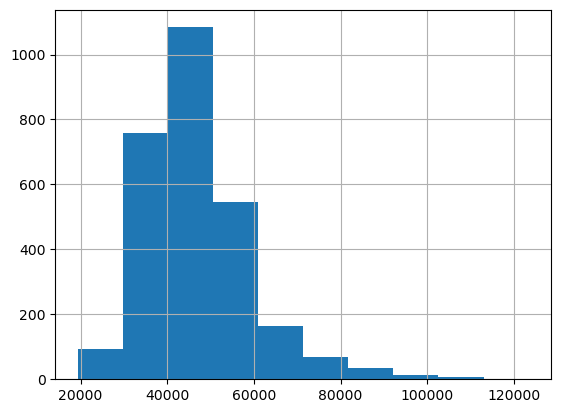

In [784]:
input_data['Med_Income'].hist()

In [785]:
input_data['med_income_log'] = np.log(input_data['Med_Income'])
input_data.head()

,All_Poverty,Med_Income,All_With,All_Without,Incidence_Rate,Mortality_Rate,State_AK,State_AL,State_AR,State_AZ,...,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY,Recent_Trend_falling,Recent_Trend_rising,Recent_Trend_stable,med_income_log
0,16551.930560,61518.0,43160.730320,55582.161030,66.1,11.785591,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,11.027085
1,8751.315328,84306.0,73254.998246,23377.762189,66.1,20.114170,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,11.342208
2,8006.160130,78326.0,81411.808032,14944.341218,61.5,47.300000,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,11.268635
3,24317.396634,51012.0,72567.703109,24974.924774,62.7,58.300000,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,10.839816
4,7735.426009,79750.0,86098.654709,21412.556054,66.1,3.146587,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,11.286652


In [843]:
X_data = input_data[['All_Poverty', 'med_income_log',
       'Incidence_Rate']]

y_data = input_data['Mortality_Rate']

# 80% traning set, 10% test set, 10% validation set

X, X_test, y, y_test = train_test_split(X_data, y_data, test_size=0.1, train_size=0.9)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.20,train_size =0.80)


In [844]:
regr_3 = linear_model.LinearRegression()
regr_3.fit(X_train,y_train)
y_pred = regr_3.predict(X_val)
print("accuracy: "+ str(regr_3.score(X_val,y_val)*100) + "%")
print("Mean absolute error: {}".format(mean_absolute_error(y_val, y_pred)))
print("Mean squared error: {}".format(mean_squared_error(y_val,y_pred)))
R2 = r2_score(y_val,y_pred)
print('R Squared: {}'.format(R2))
n = X_val.shape[0]
p = X_val.shape[1] - 1

adj_rsquared = 1 - (1 - R2) * ((n - 1)/(n-p-1))
print('Adjusted R Squared: {}'.format(adj_rsquared))

accuracy: 71.16728092275466%
Mean absolute error: 6.014396021476584
Mean squared error: 81.07084943388789
R Squared: 0.7116728092275465
Adjusted R Squared: 0.7105078508809911


### 3.3 Model selection [10 Marks]
Using different model selection criteria and validation dataset, choose the single best perfoming model among the three models.

For selecting the best model among different linear regression models run we are evaluating the following criterias: 
    
- **R sqaured value**: A high R-squared value indicates that the model fits the data well, while a low R-squared value indicates that the model does not fit the data well. Among the 3 different models that we ran, Model 2 gives the highest R sqaured value on the validation set. The R-squared value for our best performing model is 72%, which means our 2nd model with the 3 most important features is able to explain ~72% variation in the validation dataset.

- **Mean Squared Error**: MSE is a measure of the average squared difference between the predicted values and the true values. A low MSE indicates that the model makes accurate predictions, while a high MSE indicates that the model makes less accurate predictions. Among the 3 models run, Model 3 has the worst MSE value whereas Model1 & Model3 have a little difference in MSE values of ~10. 

- **Mean Absolute Error**: MAE is a measure of the average absolute difference between the predicted values and the true values. Like MSE, a low MAE indicates that the model makes accurate predictions, while a high MAE indicates that the model makes less accurate predictions. Among the 3 models run, Model 3 has the worst MAE values whereas Model1 & Model3 have almost similar MAE values of 5.7 and 6 respectively. 


Although Model1 and Model3 have similar MAE & MSE values, the R squared value for Model2 trumps that of Model3, indicating a better fit despite comparable MSE values. Hence we have decided to go ahead with **Model 2** as the single best performing model. Another reason would be the feature selection process, as in Model 2 we are using the 3 best features for our linear regression model as given by the Random Forest Feature Selection process. This way, our model is not too complex, and easy to explain using these 3 simple continuous variables.


    

## **Part 4: Model diagnostics [10 marks]**
Explore model collinearity with `variance_inflation_factor`. Larger values of VIF indicate multicollinearity. Remove the problematic features and refit the model. Report how model R-squared is affected.

*Hint:* Consider VIF > 10 as an indicator of multicollinearity. If the VIF for all your features is below 10, it is a positive indication that the level of collinearity is acceptably low without any changes to the model needed in this step.

In [811]:
from patsy import dmatrices

df = input_data[['All_Poverty',
       'Incidence_Rate', 'Med_Income', 'Mortality_Rate']]

In [812]:
formula = 'Mortality_Rate ~ All_Poverty + Med_Income + Incidence_Rate'

# get y and X dataframes based on this regression:
y_feat, X_feat = dmatrices(formula, df, return_type='dataframe')

vif = pd.DataFrame()
vif["features"] = X_feat.columns
vif["VIF Factor"] = [variance_inflation_factor(X_feat.values, i) for i in range(len(X_feat.columns))]

In [813]:
vif

,features,VIF Factor
0,Intercept,116.826440
1,All_Poverty,2.463059
2,Med_Income,2.568158
3,Incidence_Rate,1.161497


Since all the VIF values are below 10, it is a positive sign indicating that the level of collinearity is acceptably low without any changes to the model needed in this step.

## **Part 5: Reporting test performance [5 marks]**
Report the MSE of the final regression model using the test set.

In [863]:
regr_2 = linear_model.LinearRegression()
regr_2.fit(X_train,y_train)
y_pred = regr_2.predict(X_test)
print("accuracy: "+ str(regr_2.score(X_test,y_test)*100) + "%")
print("Mean absolute error: {}".format(mean_absolute_error(y_test, y_pred)))
print("Mean squared error: {}".format(mean_squared_error(y_test,y_pred)))
R2 = r2_score(y_test,y_pred)
print('R Squared: {}'.format(R2))
n = X_val.shape[0]
p = X_val.shape[1] - 1

adj_rsquared = 1 - (1 - R2) * ((n - 1)/(n-p-1))
print('Adjusted R Squared: {}'.format(adj_rsquared))

accuracy: 74.21002617041066%
Mean absolute error: 5.465638235792599
Mean squared error: 73.56658125864192
R Squared: 0.7421002617041066
Adjusted R Squared: 0.7410582425594767


The R squared value for our test set using Model 2 is considerably higher than the validation set indicating that this model is a good fit and predicts ~74% accurate results. 

## **Part 6: Alternative predictive model (optional): [20 bonus points up to the maximum mark]**

Use one other supervised learning model to outperform the regression model from part 5 (in terms of MSE) on the same hold-out test set. Document, justify, and explain all your decision w.r.t. the implementation of this alternative predictive model.

This part is deliberately designed without clear instructions as bonus points for efforts of groups in completing a very common ML task without a walkthrough or instrcutions.

We have chosen the same 3 features from our best model (Model 2) and tried to use them in different models to enhance and further see how it chnages the accuracy. 

### Alternative Model 1: XG boost Model 

XGBoost(Extreme Gradient Boosting) provides parallel tree boosting.Here we have split the dataset into train and test data only.

We have trained the model by setting the hyper parameters n_estimator: 100 in order to build a 100 trees for training and learning rate as 0.05(step size) to prevent overfitting.
The R-squared value for this model while predicting the test data is approximately 0.72
It would be reasonable to say that this is a good model to predict the mortality rate.

In [3]:
!pip install xgboost

In [90]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X_data = input_data[['All_Poverty', 'Med_Income',
       'Incidence_Rate']]

y_data = input_data['Mortality_Rate']

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.1, random_state=0)
# Create an XGBoost model
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.05, random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

Mean Squared Error: 84.13880683721992
R-squared: 0.7087019391213778


### Alternative Model 2: Fitting Regression Trees 

This model regression attempts to forecast a continuous output value from a set of input features. Here as well we have split the data set in just 2, training and testing data. 

The Random Forest Regressor functions by building numerous decision trees and integrating their forecasts via a procedure known as voting or averaging. This is done to produce a prediction that is more precise and stable than the predictions made by a single decision tree. The R sqaured value of 73% indicates best fit amongst all the models we have run so far. 

In [92]:
all_features = X_train.shape[1]
regr_bagging = RandomForestRegressor(max_features=all_features, random_state=4)
regr_bagging.fit(X_train, y_train)

y_pred = regr_bagging.predict(X_test)

r2 = r2_score(y_test, y_pred)

print("R-squared:", r2)

regr_rf = RandomForestRegressor(max_features=3, random_state=1)
regr_rf.fit(X_train, y_train)


R-squared: 0.7331534218541939


RandomForestRegressor(max_features=3, random_state=1)